## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
# using Piccolo
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
# using Plots
using SparseArrays
using Statistics
using CairoMakie
using Random
using NamedTrajectories

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryUniversalProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryUniversalProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243


In [2]:
# Problem parameters
T = 40
Δt = 0.8
U_goal = GATES.H
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drive)
seeds = rand(1:1000, 25)
F=0.9999
num_iter = 6000
hess = false
hess_iter = 120
Qs = 10 .^ range(-4.0, 1.0, length=25)
a_bound = 1.0
dda_bound = 0.5
R=5e-3

0.005

In [35]:
using JLD2, FileIO
using CairoMakie
using Statistics

# Directories where data is saved
var_dir = "artifacts/var_gap_data_export"
tog_dir = "artifacts/tog_gap_data_export"

# Load the first seed file to get metadata
var_first = load(joinpath(var_dir, "var_probs_seed_idx_1.jld2"))
tog_first = load(joinpath(tog_dir, "htog_probs_seed_idx_1.jld2"))

# Extract common parameters
Qs = var_first["Qs"]

n_seeds = length(readdir(var_dir)) - 1  # Subtract 1 for plot.png

# Initialize arrays to store loaded data
var_probs = Matrix{Any}(undef, n_seeds, length(Qs))
htog_probs = Matrix{Any}(undef, n_seeds, length(Qs))

# Load all var_probs data
for i in 1:n_seeds
    data = load(joinpath(var_dir, "var_probs_seed_idx_$(i).jld2"))
    var_probs[i, :] = data["var_probs"]
end

# Load all htog_probs data
for i in 1:n_seeds
    data = load(joinpath(tog_dir, "htog_probs_seed_idx_$(i).jld2"))
    htog_probs[i, :] = data["htog_probs"]
end

println("Loaded data for $(n_seeds) seeds across $(length(Qs)) Q values")

Loaded data for 25 seeds across 25 Q values


In [36]:
Qs = Qs[1:end-4]
var_probs = var_probs[:, 1:end-4]
htog_probs = htog_probs[:, 1:end-4]

25×21 Matrix{Any}:
 DirectTrajOptProblem
   timesteps            = 40
   duration             = 31.2
   variable names       = (:Ũ⃗, :a, :da, :dda, :Δt)
   knot point dimension = 18
  …  DirectTrajOptProblem
   timesteps            = 40
   duration             = 31.2
   variable names       = (:Ũ⃗, :a, :da, :dda, :Δt)
   knot point dimension = 18

 DirectTrajOptProblem
   timesteps            = 40
   duration             = 31.2
   variable names       = (:Ũ⃗, :a, :da, :dda, :Δt)
   knot point dimension = 18
     DirectTrajOptProblem
   timesteps            = 40
   duration             = 31.2
   variable names       = (:Ũ⃗, :a, :da, :dda, :Δt)
   knot point dimension = 18

 DirectTrajOptProblem
   timesteps            = 40
   duration             = 31.2
   variable names       = (:Ũ⃗, :a, :da, :dda, :Δt)
   knot point dimension = 18
     DirectTrajOptProblem
   timesteps            = 40
   duration             = 31.2
   variable names       = (:Ũ⃗, :a, :da, :dda, :Δt)
   knot point dime

In [37]:
# Adjoint, rollout initialization

∂ₑHₐ = [PAULIS.Z]
varsys_add = VariationalQuantumSystem(
    H_drive,
    ∂ₑHₐ
)
n_seeds = length(seeds)
nQ = length(Qs)

21

In [5]:
var_prob[1].trajectory.Δt[1], var_prob[1].trajectory.Δt[end ÷ 2]

UndefVarError: UndefVarError: `var_prob` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [38]:
∂ₑH = [PAULIS.Z]
H_drives = [PAULIS.X, PAULIS.Y, PAULIS.Z]
error_ops = [PAULIS.Z]

function var_obj(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}}, 
    H_errors::Vector{Matrix{ComplexF64}}
)
    Δt = traj.Δt[1]
    varsys = VariationalQuantumSystem(H_drives, H_errors)
    Ũ⃗, ∂Ũ⃗ = variational_unitary_rollout(traj, varsys)

    U = iso_vec_to_operator(Ũ⃗[:, end])
    # First error term
    ∂U = iso_vec_to_operator(∂Ũ⃗[1][:, end])

    d = size(U, 1)
    return abs(tr((U'*∂U)'*(U'*∂U))) / (T * Δt)^2 / d
end

# J_var = var_obj(var_prob.trajectory, H_drives, error_ops)

var_obj (generic function with 1 method)

In [39]:
function tog_obj(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}},
    H_error::Matrix{ComplexF64}
)
    T = traj.T
    Δt = get_timesteps(traj)

    sys = QuantumSystem(H_drives)
    U = iso_vec_to_operator.(eachcol(unitary_rollout(traj, sys)))
    
    # Toggle integral
    H_ti = sum(Δt[i] .* U[i]' * H_error * U[i] for i=1:T-1)

    d₁ = size(U[1], 1)
    Δt₁ = Δt[1]
    metric = norm(tr(H_ti'H_ti)) / (T * Δt₁)^2 / d₁
    return metric
end


tog_obj (generic function with 1 method)

In [40]:
function commutator(A::AbstractMatrix{<:Number}, B::AbstractMatrix{<:Number})
    return A*B - B*A
end

commutator (generic function with 1 method)

In [41]:
function pert_tog_obj(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}},
    H_error::Matrix{ComplexF64};
    order::Int=1,
    a_bound::Float64=a_bound
)
    T = traj.T
    Δt = get_timesteps(traj)

    sys = QuantumSystem(H_drives)
    U = iso_vec_to_operator.(eachcol(unitary_rollout(traj, sys)))

    # toggle integral
    H_ti = zeros(ComplexF64, size(U[1]))

    # note: U_1 = I, so U[:, k] = U_{k-1}.
    # you need to go to T-1, only
    for k in 1:T-1
        Hₖ = sum(traj.a[l, k] / a_bound * H for (l, H) in enumerate(H_drives))
        adjⁿH_E = H_error
        Eₖ_n = H_error * Δt[k]
        
        # get the different orders of the Hadamard lemma
        for n in 2:order
            coef_n = ComplexF64(im^(n-1) * a_bound^(n-1) * Δt[k]^n / factorial(big(n)))
            adjⁿH_E = commutator(Hₖ, adjⁿH_E)
            # Eₖ_n = push!(Eₖ_n, coef_n * adjⁿH_E)
            Eₖ_n += coef_n * adjⁿH_E
        end

        # nth order toggle integral up to k
        H_ti += U[k]' * Eₖ_n * U[k]
    end

    d₁ = size(U[1], 1)
    Δt₁ = Δt[1]
    metric = norm(tr(H_ti'H_ti)) / (T * Δt₁)^2 / d₁
    return metric
end

pert_tog_obj (generic function with 1 method)

In [11]:
pert_tog_obj(var_prob.trajectory, H_drives, PAULIS.Z, order=1)

UndefVarError: UndefVarError: `var_prob` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [42]:
var_obj_vals = []
var_objs_sem = []
for (j, Q) in enumerate(Qs)
    var_obj_val_seeds = []
    for (i, seed) in enumerate(seeds)
        Z_vec = vec(var_probs[i,j].trajectory)
        push!(var_obj_val_seeds, var_probs[i,j].objective.L(Z_vec))
    end
    push!(var_obj_vals, mean(var_obj_val_seeds))
    push!(var_objs_sem, std(var_obj_vals) / sqrt(n_seeds))
end

tog_obj_vals = []
tog_objs_sem = []

for (j, Q) in enumerate(Qs)
    tog_obj_val_seeds = []
    for (i, seed) in enumerate(seeds)
        Z_vec = vec(htog_probs[i,j].trajectory)
        push!(tog_obj_val_seeds, htog_probs[i,j].objective.L(Z_vec))
    end
    push!(tog_obj_vals, mean(tog_obj_val_seeds))
    push!(tog_objs_sem, std(tog_obj_vals) / sqrt(n_seeds))
end




In [43]:
"""
    upsample_constant(vals, dts; factor=2)

Take control values `vals` with time steps `dts` (same length),
and upsample by `factor`, returning (vals_up, dts_up).
"""
function upsample_constant_controls(vals::AbstractArray; factor::Int=2)
    vals_up = repeat(vals, inner=factor)
    return vals_up
end

# Example
vals = [1, 2, 3]
dts  = [0.2, 0.2, 0.2]

vals_up = upsample_constant_controls(vals; factor=3)

println(vals_up)  # [1, 1, 2, 2, 3, 3]
#println(dts_up) 
function upsample_matrix(controls::AbstractArray, dts::AbstractArray; factor::Int=2)
    new_controls = []
    for c in eachrow(controls)
        new_c = upsample_constant_controls(c; factor=factor)
        T = length(c)
        push!(new_controls, new_c)
    end
    dts_up = dts[1] / factor .* ones(length(dts) * factor*T)
    new_controls = reduce(vcat, [v' for v in new_controls])
    return new_controls, dts_up
end
function tog_obj_upsample(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}},
    H_error::Matrix{ComplexF64};
    factor::Int=1
)
    T = traj.T * factor
    controls = traj.a
    a_new, Δt_new = upsample_matrix(traj.a, traj.Δt; factor=factor)

    sys = QuantumSystem(H_drives)
    U = iso_vec_to_operator.(eachcol(unitary_rollout(a_new, Δt_new, sys)))
    
    # Toggle integral (truncate at (traj.T - 1) * factor)
    H_ti = sum(Δt_new[i] .* U[i]' * H_error * U[i] for i = 1:(traj.T - 1) * factor)

    d₁ = size(U[1], 1)
    Δt₁ = Δt_new[1]
    metric = norm(tr(H_ti'H_ti)) / (T * Δt₁)^2 / d₁
    return metric
end

[1, 1, 1, 2, 2, 2, 3, 3, 3]


tog_obj_upsample (generic function with 1 method)

In [14]:
# j_vals = 10:10
# length(j_vals)

In [44]:
j_vals = 5:5
n_js = length(j_vals)
H_errors = [GATES.Z]
t_vec = Matrix{Any}(undef, n_js, length(Qs))
v_vec = Matrix{Any}(undef, n_js, length(Qs))

for (j_idx, j) in enumerate(j_vals)
    for (k, Q) in enumerate(Qs)
        t_vec_seed = []
        v_vec_seed = []
        for (i, seed) in enumerate(seeds)
            push!(t_vec_seed, tog_obj_upsample(htog_probs[i,k].trajectory, H_drives, PAULIS.Z; factor=2^j))
            push!(v_vec_seed, tog_obj_upsample(var_probs[i,k].trajectory, H_drives, PAULIS.Z; factor=2^j))
        end
        t_vec[j_idx, k] = mean(t_vec_seed)
        v_vec[j_idx, k] = mean(v_vec_seed)
    end
end

In [45]:
# Process var_probs data (left plot)
var_tog_objs = []
var_tog_vars = []
var_tog_pert1 = []

var_tog_objs_sem = []
var_tog_vars_sem = []
var_tog_pert1_sem = []
for (j, Q) in enumerate(Qs)
    objs_at_Q = [tog_obj(var_probs[i,j].trajectory, H_drives, error_ops[1]) for i in 1:n_seeds]
    vars_at_Q = [var_obj(var_probs[i,j].trajectory, H_drives, error_ops) for i in 1:n_seeds]
    pert1_at_Q = [pert_tog_obj(var_probs[i,j].trajectory, H_drives, PAULIS.Z, order=2) for i in 1:n_seeds]
    
    push!(var_tog_objs, mean(objs_at_Q))
    push!(var_tog_vars, mean(vars_at_Q))
    push!(var_tog_pert1, mean(pert1_at_Q))
    
    push!(var_tog_objs_sem, std(objs_at_Q) / sqrt(n_seeds))
    push!(var_tog_vars_sem, std(vars_at_Q) / sqrt(n_seeds))
    push!(var_tog_pert1_sem, std(pert1_at_Q) / sqrt(n_seeds))
end

# Process htog_probs data (right plot)
htog_tog_objs = []
htog_tog_vars = []
htog_tog_pert = []

htog_tog_objs_sem = []
htog_tog_vars_sem = []
htog_tog_pert_sem = []

for (j, Q) in enumerate(Qs)
    objs_at_Q = [tog_obj(htog_probs[i,j].trajectory, H_drives, error_ops[1]) for i in 1:n_seeds]
    vars_at_Q = [var_obj(htog_probs[i,j].trajectory, H_drives, error_ops) for i in 1:n_seeds]
    pert_at_Q = [pert_tog_obj(htog_probs[i,j].trajectory, H_drives, PAULIS.Z, order=2) for i in 1:n_seeds]
    
    push!(htog_tog_objs, mean(objs_at_Q))
    push!(htog_tog_vars, mean(vars_at_Q))
    push!(htog_tog_pert, mean(pert_at_Q))
    
    push!(htog_tog_objs_sem, std(objs_at_Q) / sqrt(n_seeds))
    push!(htog_tog_vars_sem, std(vars_at_Q) / sqrt(n_seeds))
    push!(htog_tog_pert_sem, std(pert_at_Q) / sqrt(n_seeds))
end

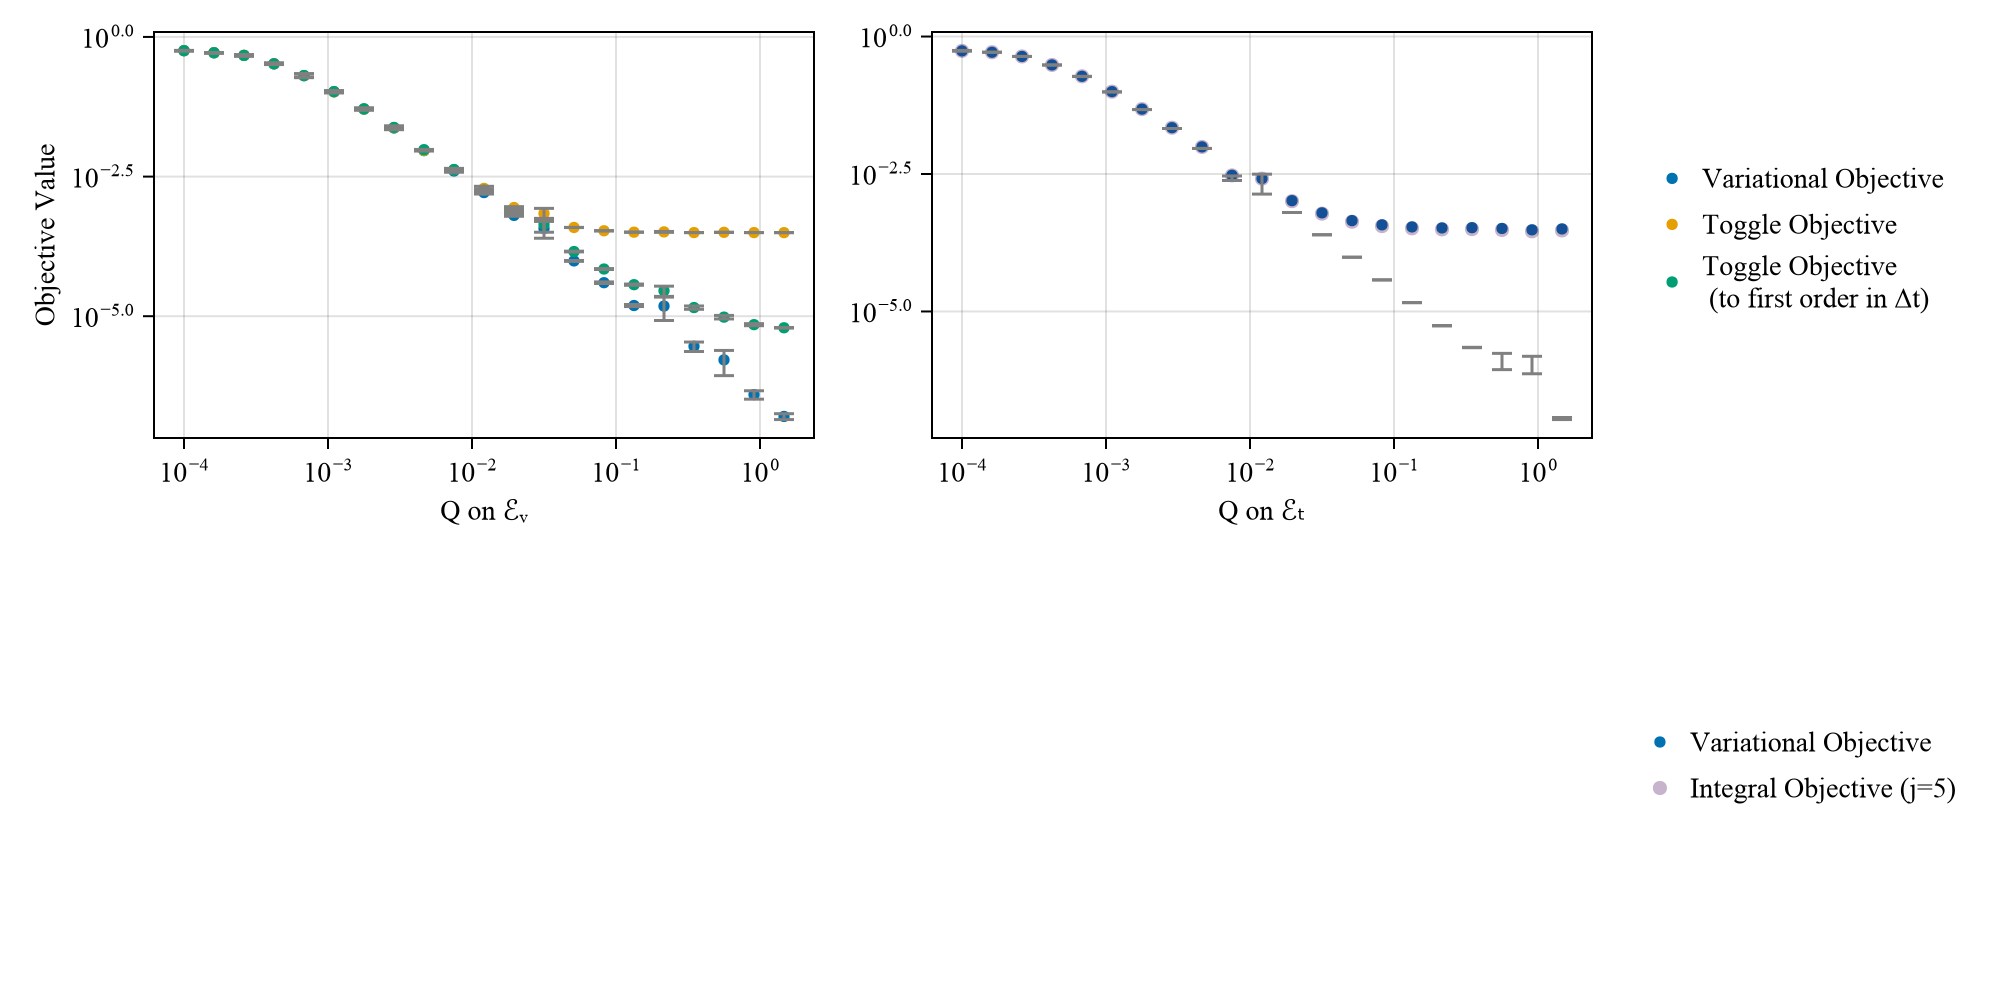

In [ ]:
var_obj_vals_Q_adj = var_obj_vals ./ Qs
tog_obj_vals_Q_adj = tog_obj_vals ./ Qs
set_theme!(fonts = (; regular = "Times New Roman"))
# Create a colormap for j values
colors = cgrad(:viridis, n_js, categorical=true)
# alphas = range(0.3, 1.0, length=n_js)  # Alternative: use alpha for shading

# Create side-by-side plots
fig = Figure(size=(1000, 500))

# Left plot: Variational-Optimized
ax1 = Axis(fig[1, 1], 
    # title="Variational-Optimized Objective Separation",
    xlabel="Q on ℰᵥ", 
    ylabel="Objective Value", 
    xscale=log10, 
    yscale=log10)

scatter!(ax1, Qs, var_tog_vars; label="Variational Objective", markersize=8)
scatter!(ax1, Qs, var_tog_objs; label="Toggle Objective", markersize=8)
# scatter!(ax1, Qs, var_tog_pert1; label="Toggle Objective \n (to first order in Δt)", markersize=8)
# scatter!(ax1, Qs, var_obj_vals_Q_adj; label="Cost Function Value", markersize=8)

# Plot v_vec for all j values with color gradient
# for (j_idx, j) in enumerate(j_vals)
#     scatter!(ax1, Qs, v_vec[j_idx, :]; 
#             label="Integral Objective (j=$j)", 
#             markersize=15, 
#             color=(colors[1], 0.3))
# end

errorbars!(ax1, Qs, var_tog_vars, var_tog_vars_sem; whiskerwidth=10,color=:gray)
errorbars!(ax1, Qs, var_tog_objs, var_tog_objs_sem; whiskerwidth=10,color=:gray)
# errorbars!(ax1, Qs, var_tog_pert1, var_tog_pert1_sem; whiskerwidth=10,color=:gray)
# errorbars!(ax1, Qs, var_obj_vals_Q_adj, var_objs_sem; whiskerwidth=10)

# Right plot: Toggle-Optimized
ax2 = Axis(fig[1, 2], 
    # title="Toggle-Optimized Objective Separation",
    xlabel="Q on ℰₜ", 
    xscale=log10, 
    yscale=log10,)

scatter!(ax2, Qs, htog_tog_vars; label="Variational Objective", markersize=8)
# scatter!(ax2, Qs, htog_tog_objs; label="Toggle Objective", markersize=8)
# scatter!(ax2, Qs, htog_tog_pert; label="Toggle Objective \n (to first order in Δt)", markersize=8)
# scatter!(ax2, Qs, tog_obj_vals_Q_adj; label="Cost Function Value", markersize=8)

# Plot t_vec for all j values with color gradient
for (j_idx, j) in enumerate(j_vals)
    scatter!(ax2, Qs, t_vec[j_idx, :]; 
            label="Integral Objective (j=$j)", 
            markersize=10, 
            color=(colors[1], .3))
end

# errorbars!(ax2, Qs, htog_tog_vars, htog_tog_vars_sem; whiskerwidth=10,color=:gray)
errorbars!(ax2, Qs, htog_tog_objs, htog_tog_objs_sem; whiskerwidth=10,color=:gray)
# errorbars!(ax2, Qs, htog_tog_pert, htog_tog_pert_sem; whiskerwidth=10,color=:gray)
# errorbars!(ax2, Qs, tog_obj_vals_Q_adj, tog_objs_sem; whiskerwidth=10)

# Add legends
Legend(fig[1, 3], ax1, framevisible=false, position = (0.1, 0.2))
Legend(fig[2, 3], ax2, framevisible=false, position = (0.1, 0.2))

fig

# Optionally save the combined figure
# save("artifacts/combined_comparison.svg", fig)


In [18]:
# display(CairoMakie.plot(def.trajectory, [:Ũ⃗, :a, :da, :dda]))
# display(CairoMakie.plot(var_prob.trajectory, [:Ũ⃗, :a]))
# display(CairoMakie.plot(tog_prob.trajectory, [:Ũ⃗, :a]))
# display(CairoMakie.plot(ftog_prob.trajectory, [:Ũ⃗, :a]))